In [1]:
import scipy
import numpy as np
import casadi as cs
import time
import torch
import gpytorch
import safe_control_gym
import time
import pybullet as p
from functools import partial
from safe_control_gym.utils.registration import make
from safe_control_gym.utils.configuration import ConfigFactory
import yaml
from safe_control_gym.controllers.mpc.mpc_utils import discretize_linear_system
from safe_control_gym.controllers.mpc.gp_utils import GaussianProcessCollection, ZeroMeanIndependentGPModel, covSEard

pybullet build time: Dec  1 2021 18:33:43


In [2]:
from safe_control_gym.controllers.lqr.lqr import LQR
from skopt.sampler import Lhs
seed = 42

In [3]:
CONFIG_FACTORY = ConfigFactory()   

In [4]:
config = CONFIG_FACTORY.merge()

/home/migooll/safe-control-gym/safe_control_gym/utils/configuration.py:72: UserWarning: No agent/task config given.
  warnings.warn("No agent/task config given.")


In [5]:
with open("cartpole.yaml", 'r') as stream:
    try:
        args = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
    
for key in args:
    config[key]=args[key]

In [6]:
config.cartpole_config['cost']=config.cartpole_config['cost'].lower()

In [7]:
env_func = partial(make, 'cartpole', **config.cartpole_config)

In [8]:
init_ctrl = make('lqr', env_func, plot_dir = "~/")

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))


/home/migooll/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [9]:
env = env_func()

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))


In [10]:
init_ctrl.reset()

In [11]:
init_ctrl.model.df_func()

{'dfdu': DM([00, 0.97561, 00, -1.46341]),
 'dfdx': DM(
 [[00, 1, 00, 00], 
  [00, 00, -0.717073, 0], 
  [00, 00, 00, 1], 
  [00, 00, 15.7756, -0]])}

In [12]:
print(init_ctrl.env.action_space)
print(init_ctrl.env.observation_space)

Box([-10.], [10.], (1,), float32)
Box([-4.8000002e+00 -3.4028235e+38 -3.1415927e+00 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 3.1415927e+00 3.4028235e+38], (4,), float32)


In [13]:
lhs_sampler = Lhs(lhs_type='classic', criterion='maximin')
train_iters = 3
val_iters = 1
limits = [(init_ctrl.env.INIT_STATE_RAND_INFO[key]['low'],init_ctrl.env.INIT_STATE_RAND_INFO[key]['high']) for key in init_ctrl.env.INIT_STATE_RAND_INFO]
samples = lhs_sampler.generate(limits, train_iters+val_iters,
                               random_state=seed)
samples = np.array(samples)

In [14]:
prior_ctrl = LQR(env_func,plot_dir='~/')
prior_ctrl.reset()

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))


In [15]:
def set_dynamics_func(prior_ctrl):
        """Updates symbolic dynamics with actual control frequency.
        """
        # Original version, used in shooting.
        # Prior dynamics taken as f(x,u)=x
        dfdx = np.eye(prior_ctrl.model.nx)
        dfdu = np.zeros((prior_ctrl.model.nx, prior_ctrl.model.nu))
        delta_x = cs.MX.sym('delta_x', prior_ctrl.model.nx,1)
        delta_u = cs.MX.sym('delta_u', prior_ctrl.model.nu,1)
        x_dot_lin_vec = dfdx @ delta_x + dfdu @ delta_u
        prior_ctrl.linear_dynamics_func = cs.integrator(
            'linear_discrete_dynamics', prior_ctrl.model.integration_algo,
            {
                'x': delta_x,
                'p': delta_u,
                'ode': x_dot_lin_vec
            }, {'tf': prior_ctrl.model.dt}
        )
        prior_ctrl.dfdx = dfdx
        prior_ctrl.dfdu = dfdu

set_dynamics_func(prior_ctrl)
prior_dynamics_func = prior_ctrl.linear_dynamics_func
        
def preprocess_training_data(x_seq, u_seq, x_next_seq):
        """Converts trajectory data for GP trianing.
        
        Args:
            x_seq (list): state sequence of np.array (nx,). 
            u_seq (list): action sequence of np.array (nu,). 
            x_next_seq (list): next state sequence of np.array (nx,). 
            
        Returns:
            np.array: inputs for GP training, (N, nx+nu).
            np.array: targets for GP training, (N, nx).
        """
        # Get the predicted dynamics. This is a linear prior, thus we need to account for the fact that
        # it is linearized about an eq using self.X_GOAL and self.U_GOAL.
        x_pred_seq = prior_dynamics_func(x0=x_seq.T - prior_ctrl.env.X_GOAL[:,None],
                                               p=u_seq.T - prior_ctrl.env.U_GOAL[:,None])['xf'].toarray()
        
        targets = (x_next_seq.T - (x_pred_seq+prior_ctrl.env.X_GOAL[:,None])).transpose()  # (N, nx).
        inputs = np.hstack([x_seq, u_seq])  # (N, nx+nu).
        return inputs, targets

/home/migooll/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): -1.00 0.00 0.00 0.00
Test Run 0 reward -58.23
initial state: -1.00 0.00 0.00 0.00
final state: -0.02 0.04 -0.00 -0.01
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
[-58.23116748]


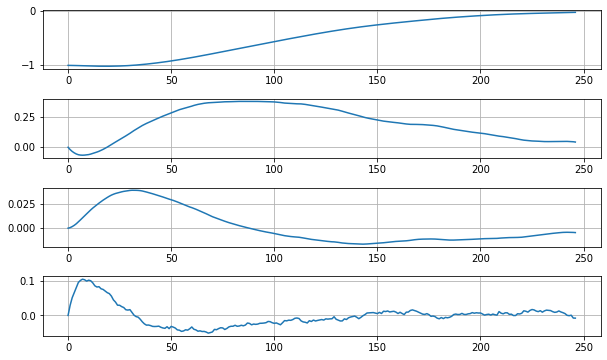

In [56]:
#Run normal gain
import matplotlib.pyplot as plt
init_state = np.array([-1.0, 0.0, 0.0, 0.0])
valid_env = prior_ctrl.env_func(init_state=init_state,
                          randomized_init=False)
post_results = init_ctrl.run(valid_env)
valid_env.close()
fig, axs = plt.subplots(prior_ctrl.x_0.shape[0],1, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

print(post_results['ep_returns'])
for d, ax in enumerate(axs.ravel()):
    ax.plot(post_results['obs'][:,d])
    ax.grid(True)

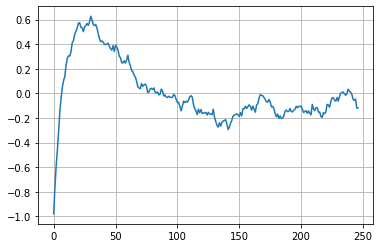

In [57]:
plt.plot(post_results['action'])
plt.grid(1)

In [17]:
train_inputs = []
train_targets = []
for i in range(train_iters+val_iters):
    init_state = samples[i,:]
    run_env = env_func(init_state=init_state, randomized_init=False)
    eval_results = init_ctrl.run(run_env)
    x_obs = eval_results["obs"]
    u_seq = eval_results["action"][:-1,:]
    x_seq = x_obs[:-1,:]
    x_next_seq = x_obs[1:,:]
    run_env.close()
    train_inputs_i, train_targets_i = preprocess_training_data(x_seq, u_seq, x_next_seq)
    train_inputs.append(train_inputs_i)
    train_targets.append(train_targets_i)


/home/migooll/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): -0.02 -0.05 0.04 -0.01
Test Run 0 reward -4.27
initial state: -0.02 -0.05 0.04 -0.01
final state: 0.03 -0.04 0.00 -0.00
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): 0.01 -0.02 -0.05 0.04
Test Run 0 reward -5.09
initial state: 0.01 -0.02 -0.05 0.04
final state: -0.03 0.04 -0.00 -0.01
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): 0.05 0.00 0.02 -0.04
Test Run 0 reward -0.24
initial state

In [18]:
from sklearn.model_selection import train_test_split
train_inputs = np.vstack(train_inputs)
train_targets = np.vstack(train_targets)
data_inputs = train_inputs
data_targets = train_targets
train_idx, test_idx = train_test_split(
                                #list(range(self.train_iterations + self.validation_iterations)),
                                list(range(train_inputs.shape[0])),
                                test_size=val_iters/(train_iters+val_iters),
                                random_state=seed
                                )
train_inputs = data_inputs[train_idx, :]
train_targets = data_targets[train_idx, :]
train_data = {'train_inputs': train_inputs, 'train_targets': train_targets}
test_inputs = data_inputs[test_idx, :]
test_targets = data_targets[test_idx, :]
test_data = {'test_inputs': test_inputs, 'test_targets': test_targets}

train_inputs_tensor = torch.Tensor(train_inputs).double()
train_targets_tensor = torch.Tensor(train_targets).double()
test_inputs_tensor = torch.Tensor(test_inputs).double()
test_targets_tensor = torch.Tensor(test_targets).double()

In [19]:
init_state = np.array([-1.0, 0.0, 0.0, 0.0])
valid_env = prior_ctrl.env_func(init_state=init_state,
                          randomized_init=False)
validation_results = prior_ctrl.run(valid_env)
valid_env.close()
x_obs = validation_results['obs']
u_seq = validation_results['action'][:-1]
x_seq = x_obs[:-1, :]
x_next_seq = x_obs[1:, :]

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): -1.00 0.00 0.00 0.00
Test Run 0 reward -58.02
initial state: -1.00 0.00 0.00 0.00
final state: -0.05 0.03 -0.00 0.00
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))


In [20]:
target_mask=np.arange(prior_ctrl.model.nx).tolist()
input_mask = np.arange(prior_ctrl.model.nx + prior_ctrl.model.nu).tolist()

In [21]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.GreaterThan(1e-6),
            ).double()
gaussian_process = GaussianProcessCollection(ZeroMeanIndependentGPModel,
                                                     likelihood,
                                                     len(target_mask),
                                                     input_mask=input_mask,
                                                     target_mask=target_mask,
                                                     normalize=False
                                                     )

In [22]:
with gpytorch.settings.cholesky_jitter(1e-1):
    gaussian_process.train(train_inputs_tensor,
                            train_targets_tensor,
                            test_inputs_tensor,
                            test_targets_tensor,
                            n_train=[3000,3000,3000,3000],
                            learning_rate=[0.1,0.1,0.1,0.1],
                            gpu=False,
                            )

#########################################
#      Training GP dimension 0         #
#########################################
Train iterations: 3000
Learning Rate:: 0.1
Iter 1/3000 - Train Loss: 0.758, Posterior loss on test data: 0.744
Iter 101/3000 - Train Loss: -4.246, Posterior loss on test data: -4.268
Iter 201/3000 - Train Loss: -5.893, Posterior loss on test data: -5.928
Iter 301/3000 - Train Loss: -5.926, Posterior loss on test data: -5.961
Iter 401/3000 - Train Loss: -5.934, Posterior loss on test data: -5.970
Iter 501/3000 - Train Loss: -5.938, Posterior loss on test data: -5.974
Iter 601/3000 - Train Loss: -5.940, Posterior loss on test data: -5.976
Iter 701/3000 - Train Loss: -5.942, Posterior loss on test data: -5.977
Iter 801/3000 - Train Loss: -5.943, Posterior loss on test data: -5.978
Iter 901/3000 - Train Loss: -5.943, Posterior loss on test data: -5.979
Iter 1001/3000 - Train Loss: -5.944, Posterior loss on test data: -5.979
Iter 1101/3000 - Train Loss: -5.944, Poster

Iter 1001/3000 - Train Loss: -4.331, Posterior loss on test data: -4.468
Iter 1101/3000 - Train Loss: -4.331, Posterior loss on test data: -4.468
Iter 1201/3000 - Train Loss: -4.331, Posterior loss on test data: -4.469
Iter 1301/3000 - Train Loss: -4.331, Posterior loss on test data: -4.469
Iter 1401/3000 - Train Loss: -4.331, Posterior loss on test data: -4.469
Iter 1501/3000 - Train Loss: -4.331, Posterior loss on test data: -4.469
Iter 1601/3000 - Train Loss: -4.331, Posterior loss on test data: -4.469
Iter 1701/3000 - Train Loss: -4.331, Posterior loss on test data: -4.469
Iter 1801/3000 - Train Loss: -4.331, Posterior loss on test data: -4.469
Iter 1901/3000 - Train Loss: -4.331, Posterior loss on test data: -4.469
Iter 2001/3000 - Train Loss: -4.332, Posterior loss on test data: -4.469
Iter 2101/3000 - Train Loss: -4.332, Posterior loss on test data: -4.469
Iter 2201/3000 - Train Loss: -4.332, Posterior loss on test data: -4.469
Iter 2301/3000 - Train Loss: -4.332, Posterior loss

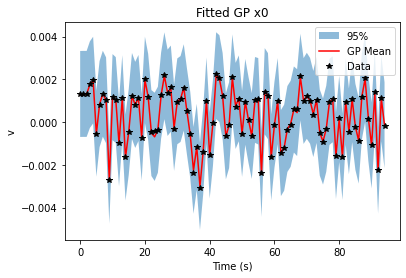

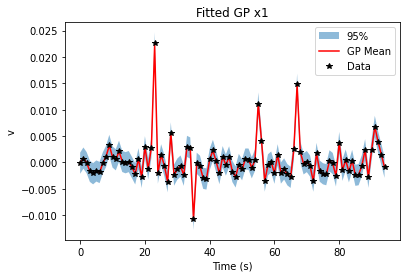

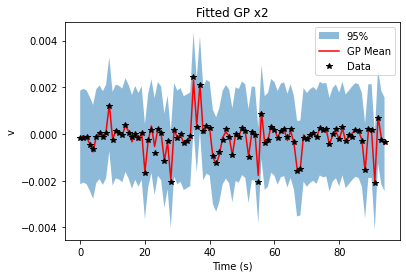

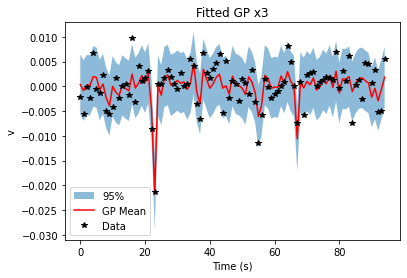

In [23]:
validation_inputs, validation_targets = preprocess_training_data(x_seq, u_seq, x_next_seq)
fig_count = 0
fig_count = gaussian_process.plot_trained_gp(test_inputs_tensor,
                                              test_targets_tensor,
                                              fig_count=fig_count)

In [24]:
lin_query = torch.tensor(np.hstack((prior_ctrl.env.X_GOAL[:,None].T,prior_ctrl.env.U_GOAL[:,None])))

In [25]:
def get_gp_jacobs(gp, query):
    mean_jacobs = []
    cov_jacobs = []
    for gp in gp.gp_list:
        mean_jacob, cov_jacob = gp.prediction_jacobian(query)
        mean_jacobs.append(mean_jacob.numpy())
        cov_jacobs.append(cov_jacob.numpy())
    mean_jacobs = np.vstack(mean_jacobs)
    cov_jacobs = 2*np.sqrt(np.vstack(cov_jacobs))
    return mean_jacobs, cov_jacobs

In [26]:
def get_gp_jacobs2(gp, query):
    mean_jacobs = []
    cov_jacobs = []
    len_scales, outscales, _, _ = gp.get_hyperparameters()
    train_inputs = gaussian_process.gp_list[0].model.train_inputs[0]
    for i, gp in enumerate(gp.gp_list):
        train_targets = gp.model.train_targets
        K_inv = gp.model.K_plus_noise_inv.detach().numpy()
        M_inv_sq = np.diag(1/(len_scales[i]**2))
        sigma_n_sq = outscales[i].numpy()
        ai_a = (train_inputs-query).numpy()
        k_ai_a = gp.model.covar_module.forward(train_inputs, query).detach().numpy()
        dk_da = np.dot(M_inv_sq, np.transpose(ai_a*k_ai_a))
        d2k_da2 = sigma_n_sq*M_inv_sq
        mean_der = dk_da@K_inv@train_targets.numpy()
        sigma_der = d2k_da2-dk_da@K_inv@dk_da.T
        mean_jacobs.append(mean_der)
        cov_jacobs.append(np.diag(sigma_der))
    mean_jacobs = np.vstack(mean_jacobs)
    cov_jacobs = 2*np.sqrt(np.vstack(cov_jacobs))
    return mean_jacobs, cov_jacobs

In [27]:
gp_jacobian, gp_uncert = get_gp_jacobs2(gaussian_process, lin_query)

In [28]:
from safe_control_gym.controllers.lqr.lqr_utils import discretize_linear_system 
A = prior_ctrl.dfdx
B = prior_ctrl.dfdu
A,B = discretize_linear_system(A, B, prior_ctrl.model.dt)

In [29]:
A_learned = A + gp_jacobian[:,:-1]
B_learned = B + gp_jacobian[:,-1].reshape(-1,1)

In [30]:
P = scipy.linalg.solve_discrete_are(A_learned, B_learned, prior_ctrl.Q, prior_ctrl.R)
btp = np.dot(B_learned.T, P)
post_gain = np.dot(np.linalg.inv(prior_ctrl.R + np.dot(btp, B_learned)),
                               np.dot(btp, A_learned))

In [31]:
init_ctrl.gain

array([[ -0.98009309,  -2.26529958, -31.58676795,  -8.10141038]])

In [32]:
post_gain

array([[ -0.5651652 ,  -2.0813222 , -30.04760653,  -7.77897374]])

/home/migooll/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): -1.00 0.00 0.00 0.00
Test Run 0 reward -65.38
initial state: -1.00 0.00 0.00 0.00
final state: -0.23 0.06 -0.00 0.01
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): -1.00 0.00 0.00 0.00
Test Run 0 reward -64.00
initial state: -1.00 0.00 0.00 0.00
final state: -0.24 0.09 -0.00 0.01
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
[-64.00394775]


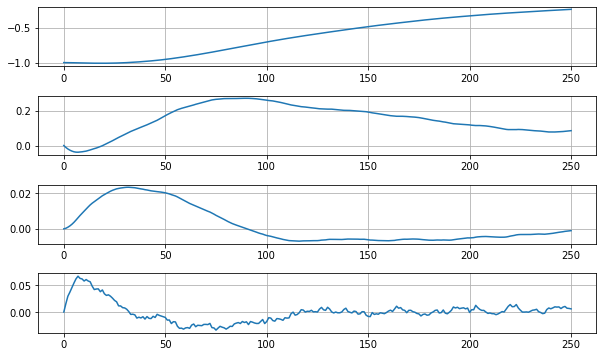

In [51]:
#Run GP learned gain (Non-Robust)
prior_ctrl.gain = post_gain
init_state = np.array([-1.0, 0.0, 0.0, 0.0])
valid_env = prior_ctrl.env_func(init_state=init_state,
                          randomized_init=False)
post_results = prior_ctrl.run(valid_env)
valid_env.close()

import matplotlib.pyplot as plt
init_state = np.array([-1.0, 0.0, 0.0, 0.0])
valid_env = prior_ctrl.env_func(init_state=init_state,
                          randomized_init=False)
post_results = prior_ctrl.run(valid_env)
valid_env.close()
fig, axs = plt.subplots(prior_ctrl.x_0.shape[0],1, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

print(post_results['ep_returns'])
for d, ax in enumerate(axs.ravel()):
    ax.plot(post_results['obs'][:,d])
    ax.grid(True)


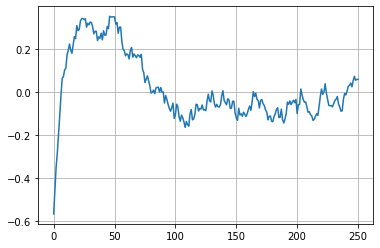

In [52]:
plt.plot(post_results['action'])
plt.grid(1)

In [35]:
Au = gp_uncert[:,:-1]
Bu = gp_uncert[:,-1]

In [36]:
# Number of states and inputs
n = prior_ctrl.env.observation_space.shape[0]
m = prior_ctrl.env.action_space.shape[0]

# Generating random values for testing (will change during actual implementation)
np.random.seed(42)
A = A_learned
B = B_learned
Bw = np.sqrt(gaussian_process.predict(lin_query)[1].detach().numpy())
Cz = np.vstack([scipy.linalg.sqrtm(prior_ctrl.Q), np.zeros((m,n))])
Dz = np.vstack([np.zeros((n,m)), scipy.linalg.sqrtm(prior_ctrl.R)])
Cq = np.vstack([np.vstack(np.eye(n)*Au[:,np.newaxis,:]), np.zeros((n*m,n))])
Dq = np.vstack([np.zeros((n*n,m)), np.vstack(np.eye(m)*Bu[:,np.newaxis])])
Bp = np.hstack([np.kron(np.eye(n),np.ones((1,n))), np.kron(np.eye(n),np.ones((1,m)))])

In [48]:
# Importing libraries
import cvxpy as cp
import numpy as np


# Dimensions (as given in the paper)
q = n
r = n + m
f = n**2 + n*m

# Defining optimization variables
W = cp.Variable((n+m,n+m), symmetric = True)
Q = cp.Variable((n,n), symmetric = True)
R = cp.Variable((m,n))
lam = cp.Variable((n**2+n*m,n**2+n*m), diag = True)
gam = cp.Variable()

# Defining parameters
bet = cp.Parameter(pos = True, value = 1.23)

# Constraints
mat_1 = cp.bmat([[W, Cz@Q + Dz@R],
                [cp.transpose(Cz@Q + Dz@R), Q]])

mat_2 = cp.bmat([[Q, np.zeros((n,q)), np.zeros((n,f)), cp.transpose(A@Q + B@R), cp.transpose(Cq@Q + Dq@R)],
                [np.zeros((q,n)), np.eye(q), np.zeros((q,f)), cp.transpose(Bw), np.zeros((q,f))],
                [np.zeros((f,n)), np.zeros((f,q)), lam, cp.transpose(Bp@lam), np.zeros((f,f))],
                [A@Q + B@R, Bw, Bp@lam, Q, np.zeros((n,f))],
                [Cq@Q + Dq@R, np.zeros((f,q)), np.zeros((f,f)), np.zeros((f,n)), bet*lam]])

constraints = [cp.trace(W) <= gam, mat_1 >> 0, mat_2 >> 0]

# Problem
prob = cp.Problem(cp.Minimize(gam), constraints)
prob.solve(solver=cp.MOSEK, verbose=True)
print("status:", prob.status)
print("optimal value", prob.value)
print("R:", R.value)
print("Q:", Q.value)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 23 08:29:28 PM: Your problem has 446 variables, 3 constraints, and 1 parameters.
(CVXPY) Apr 23 08:29:28 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 23 08:29:28 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 23 08:29:28 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Apr 23 08:29:28 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Apr 23 08:29:28 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 23 08:29:28 PM: Applying reduction CvxAttr2Constr
(CVXP

(CVXPY) Apr 23 08:29:28 PM: 26  4.9e-15  8.0e-16  4.2e-16  6.52e-01   2.845904278e+01   2.844810998e+01   8.0e-16  0.08  
(CVXPY) Apr 23 08:29:28 PM: 27  1.8e-15  6.7e-17  8.8e-18  9.70e-01   2.890289108e+01   2.890204805e+01   6.1e-17  0.08  
(CVXPY) Apr 23 08:29:28 PM: 28  4.9e-15  6.7e-17  8.1e-18  9.98e-01   2.890504704e+01   2.890425150e+01   5.7e-17  0.09  
(CVXPY) Apr 23 08:29:28 PM: 29  7.5e-15  6.7e-17  8.1e-18  9.98e-01   2.890505103e+01   2.890425557e+01   5.7e-17  0.09  
(CVXPY) Apr 23 08:29:28 PM: 30  7.5e-15  6.7e-17  8.1e-18  9.98e-01   2.890505103e+01   2.890425557e+01   5.7e-17  0.10  
(CVXPY) Apr 23 08:29:28 PM: 31  7.5e-15  6.7e-17  8.1e-18  9.98e-01   2.890505103e+01   2.890425557e+01   5.7e-17  0.11  
(CVXPY) Apr 23 08:29:28 PM: 32  7.1e-15  1.2e-16  8.1e-18  9.98e-01   2.890505302e+01   2.890425761e+01   5.7e-17  0.11  
(CVXPY) Apr 23 08:29:28 PM: 33  7.5e-15  7.2e-17  8.1e-18  9.97e-01   2.890506894e+01   2.890427388e+01   5.7e-17  0.12  
(CVXPY) Apr 23 08:29:28 

[[ 22.96796893  59.8209326  325.38885623  76.60821576]]
@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
initial state (1): -1.00 0.00 0.00 0.00
Test Run 0 reward -192.64
initial state: -1.00 0.00 0.00 0.00
final state: -0.11 0.07 -0.00 -0.01
goal state: 0.00 0.00 0.00 0.00

@1=vertcat(x, x_dot, theta, theta_dot), (mac(mac((0.5*(@1-Xr)'),Q,zeros(1x4)),(@1-Xr),0)+(((0.5*(U-Ur))*R)*(U-Ur)))
[-192.64378821]


/home/migooll/.local/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


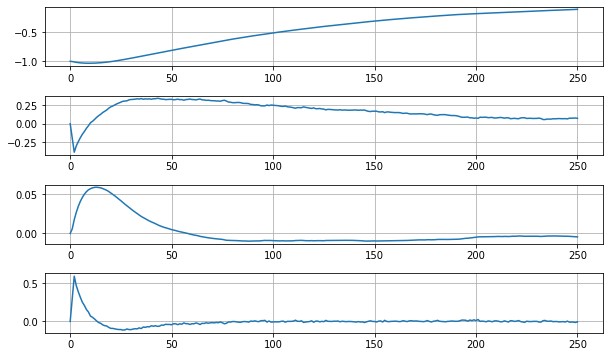

In [54]:
#Run robust gain
robust_K = R.value@np.linalg.inv(Q.value)
print(robust_K)
prior_ctrl.gain = -robust_K
init_state = np.array([-1.0, 0.0, 0.0, 0.0])
valid_env = prior_ctrl.env_func(init_state=init_state,
                          randomized_init=False)
post_results = prior_ctrl.run(valid_env)
valid_env.close()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(prior_ctrl.x_0.shape[0],1, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

print(post_results['ep_returns'])
for d, ax in enumerate(axs.ravel()):
    ax.plot(post_results['obs'][:,d])
    ax.grid(True)


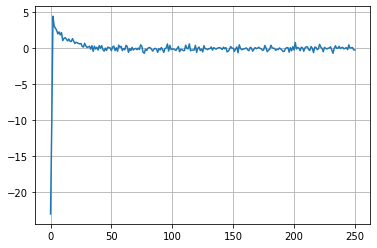

In [55]:
plt.plot(post_results['action'])
plt.grid(1)